In [11]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.externals.six import StringIO
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image 

# FAZENDO O DOWNLOAD DO DATASET
%pip install wget
!wget https://raw.githubusercontent.com/diogocortiz/Crash-Course-IA/master/ArvoreDecis%C3%A3o/dataset_einstein.csv


# IMPORTANDO O DATASET PARA O DATAFRAME
df = pd.read_csv('dataset_einstein.csv', delimiter=';')

# MOSTRANDO AS PRIMEIRAS CINCO LINHAS
print(df.head(5))

count_row = df.shape[0]  # PEGANDO OS NÚMEROS DE REGISTROS
count_col = df.shape[1]  # PEGANDO OS NUMEROS DE COLUNAS

print(count_row)
print(count_col)
# REPAREM QUE HÁ MUITOS REGISTROS EM QUE HÁ DADOS FALTANDO NOS CAMPOS 

Note: you may need to restart the kernel to use updated packages.
--2024-01-23 12:28:29--  https://raw.githubusercontent.com/diogocortiz/Crash-Course-IA/master/ArvoreDecis%C3%A3o/dataset_einstein.csv
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 248868 (243K) [text/plain]
Salvando em: ‘dataset_einstein.csv’

dataset_einstein.cs 100%[===================>] 243,04K  --.-KB/s    em 0,02s   

2024-01-23 12:28:30 (14,1 MB/s) - ‘dataset_einstein.csv’ salvo [248868/248868]

        Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negat

#### Precisamos deixar o dataset somente com os registros que tenham todos os campos (para evitar ruídos e distorções)



In [12]:
# REMOVENDO OS REGISTROS NOS QUAIS PELO MENOS UM CAMPO ESTÁ EM BRANCO (NAN) 
df = df.dropna()

print(df.head(5))

print('Quantidade de campos(colunas): ', df.shape[1])
print('Total de registros:', df.shape[0])

#VAMOS VERIFICAR SE O BANCO DE DADOS ESTÁ BALANCEADO OU DESBALANCEADO
print ('Total de registros negativos: ', df[df['SARS-Cov-2 exam result'] =='negative'].shape[0])
print ('Total de registros positivos: ', df[df['SARS-Cov-2 exam result'] =='positive'].shape[0])

         Patient ID  Patient age quantile SARS-Cov-2 exam result  \
1   126e9dd13932f68                    17               negative   
8   8bb9d64f0215244                     1               negative   
28  fc41531ca4faf1e                    13               negative   
29  891d0f6449ff3d7                    14               negative   
30  ebdd7c67fcb21b4                     9               negative   

    Patient addmited to regular ward (1=yes. 0=no)  \
1                                                0   
8                                                0   
28                                               0   
29                                               0   
30                                               1   

    Patient addmited to semi-intensive unit (1=yes. 0=no)  \
1                                                   0       
8                                                   1       
28                                                  0       
29                    

##### Precisamos converter o Dataframe para um Array Numpy, que é o tipo de dados que iremos usar no treinamento. Também iremos já separar o Dataset em dois. Um com as features de entrada, e outro com os labels (etiquetas, rótulos do registro).

Neste caso, estamos tentando fazer um classificador para o teste do Covid, neste caso, queremos treinar o nosso modelo com a etiqueta presente no campo 'SARS-Cov-2 exam result'

In [13]:
# VAMOS JOGAR AS ETIQUETAS PARA Y
Y = df['SARS-Cov-2 exam result'].values 
print(Y)

# X SERÁ A NOSSA MATRIZ COM AS FEATURES
# VAMOS PEGAR OS CAMPOS DE TREINAMENTO (Hemoglobin, Leukocytes, Basophils, Proteina C reativa mg/dL)

X = df[['Hemoglobin', 'Leukocytes', 'Basophils','Proteina C reativa mg/dL']].values

# VAMOS MOSTRAR X 
print(X)

['negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'negative' 'negative' 'negative'
 'negative' 'negative' 'negative' 'positive' 'negative' 'negat

##### Agora precisamos dividir o nosso Dataset em dois: um para o treino (80% dos dados) e outro para o teste (20% dos dados)



In [14]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size=0.2, random_state=3)

##### Agora vamos criar o e treinar o nosso modelo. Lembram da diferença entre algortimo e modelo? Existe o algortimo de treinamento (que neste caso é o de árvore de decisão) que irá exportar um modelo treinado (que também é um algoritmo).

In [15]:
# CRIAR UM ALGORTIMO QUE SERÁ DO TIPO DE ÁRVORE DE DECISÃO

algortimo_arvore = DecisionTreeClassifier(criterion='entropy', max_depth=5)
# AGORA EM MINHA_ARVORE EU TENHO ASSOCIADA A ELA O ALGORITMO DE TREINAMENTO, 
# BASICAMENTE A RECEITA QUE VIMOS NA PARTE TÉORICA. 

#AGORA PRECISAMOS TREINÁ-LA
modelo = algortimo_arvore.fit(X_treino, Y_treino)

##### A árvore de decisão pode ser considerada um modelo White Box, ou seja, um modelo que podemos entender melhor o que ele aprendeu e como ele decide. Podemos mostrar a árvore para isso.



[0.13553694 0.56306579 0.18040441 0.12099287]


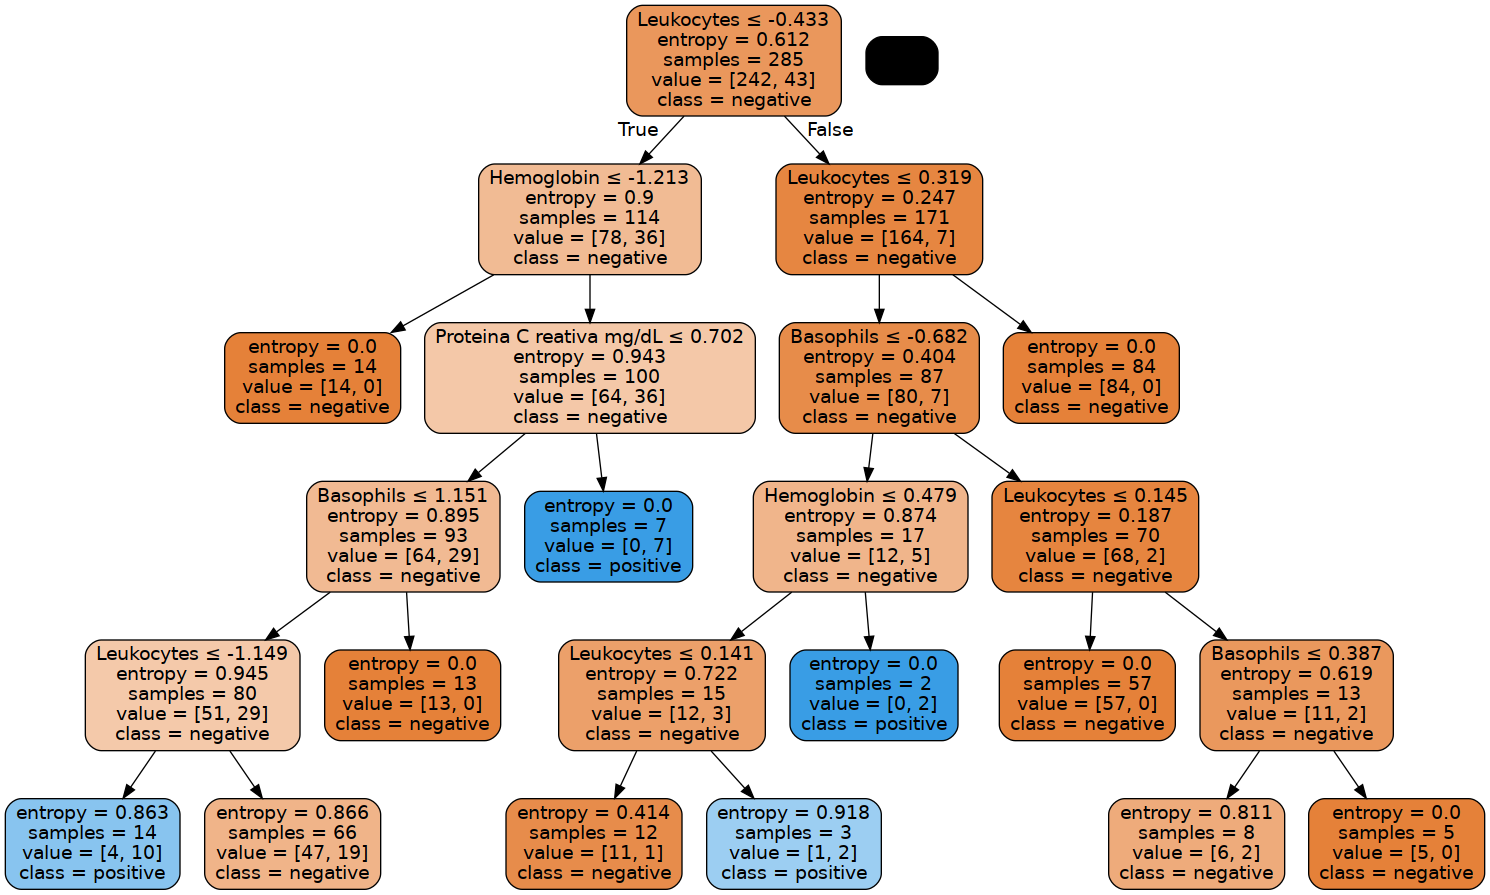

In [16]:
#PODEMOS MOSTRAR A FEATURE MAIS IMPORTANTE (WHITE BOX?)
print (modelo.feature_importances_)


nome_features = ['Hemoglobin', 'Leukocytes', 'Basophils','Proteina C reativa mg/dL']
nome_classes = modelo.classes_

# MONTAR A IMAGEM DA ÁRVORE
dot_data = StringIO()
#dot_data = tree.export_graphviz(my_tree_one, out_file=None, feature_names=featureNames)
export_graphviz(modelo, out_file=dot_data, filled=True, feature_names=nome_features, class_names=nome_classes, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
graph.write_png("arvore.png")
Image('arvore.png')

##### E podemos entender também quais as features de maior importância para o modelo treinado



Feature ranking:
1. feature 1 (0.563066)
2. feature 2 (0.180404)
3. feature 0 (0.135537)
4. feature 3 (0.120993)


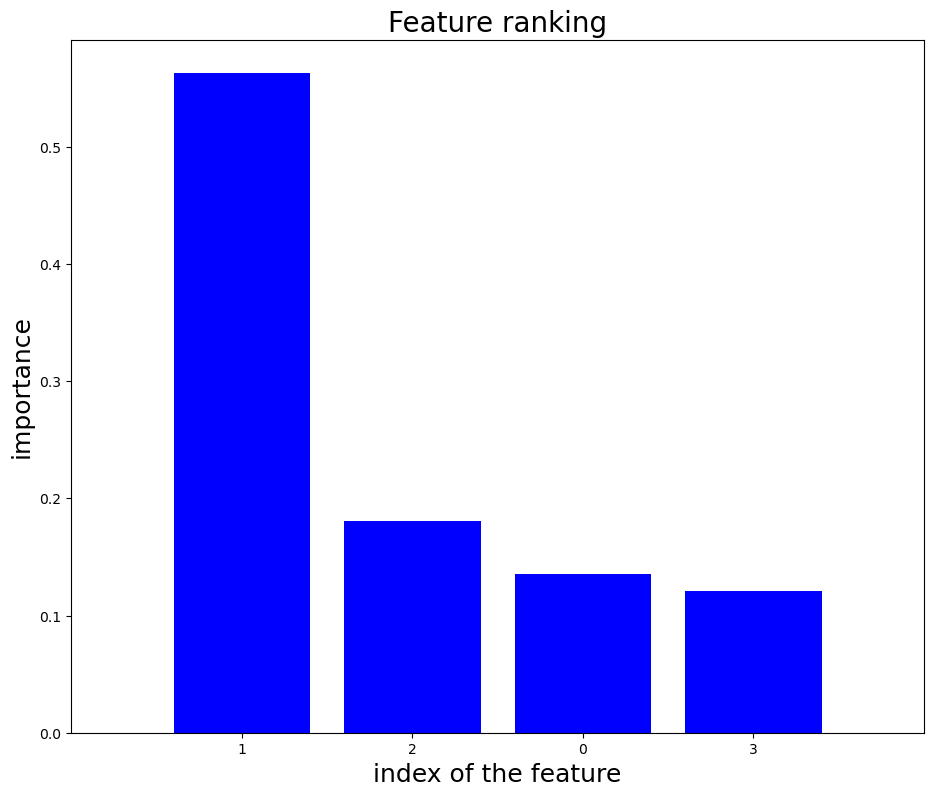

In [17]:
importances = modelo.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

#Indice das features
# 0 - 'Hemoglobin', 
# 1 - 'Leukocytes'
# 2 - 'Basophils',
# 3 - 'Proteina C reativa mg/dL']

##### Vamos testar o modelo, fazendo as predições no dataset de teste.



In [18]:
# APLICANDO O MODELO NA BASE DE TESTES E ARMAZENDO O RESULTADO EM Y_PREDICOES
Y_predicoes = modelo.predict(X_teste)

#AVALIAÇÃO DO MODELO 
#VAMOS AVALIAR O VALOR REAL DO DATASET Y_TESTE COM AS PREDIÇÕES
print("ACURÁCIA DA ÁRVORE: ", accuracy_score(Y_teste, Y_predicoes))
print (classification_report(Y_teste, Y_predicoes))

# PRECISÃO: DAS CLASSIFICAÇÕES QUE O MODELO FEZ PARA UMA DETERMINADA CLASSE
# RECALL: DOS POSSÍVEIS DATAPOINTS PERTECENTES A UMA DETERMINADA CLASSE

ACURÁCIA DA ÁRVORE:  0.8472222222222222
              precision    recall  f1-score   support

    negative       0.87      0.97      0.91        60
    positive       0.60      0.25      0.35        12

    accuracy                           0.85        72
   macro avg       0.73      0.61      0.63        72
weighted avg       0.82      0.85      0.82        72



##### Vamos entender a Matriz de Confusão



Matriz de Confusão sem normalizacão 
[[58  2]
 [ 9  3]]


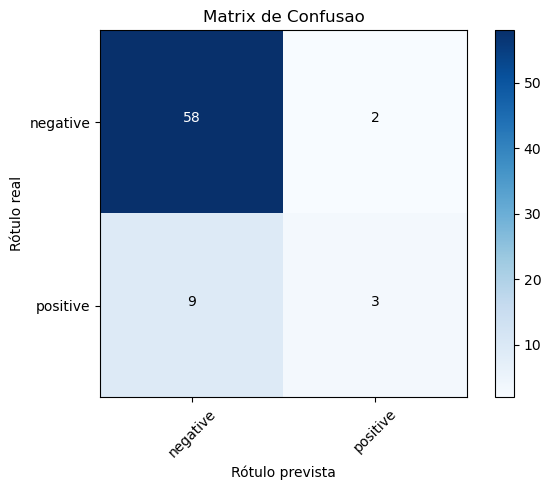

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão sem normalizacão ')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo real')
    plt.xlabel('Rótulo prevista')

matrix_confusao = confusion_matrix(Y_teste, Y_predicoes)
plt.figure()
plot_confusion_matrix(matrix_confusao, classes=nome_classes,
                      title='Matrix de Confusao')